In [1]:
import msprime
import numpy as np
import matplotlib.pyplot as plt
import demesdraw
import moments
import dadi
import time 
import nlopt
from tqdm import tqdm


# Playing around with the split isolation model

In [69]:
upper_bound_params = {
    "t_split": 5000, 
    "m": 1e-4,
    "N1": 10000,
    "N2": 10000,
    "Na": 20000
}

lower_bound_params =  {
    "t_split": 100, 
    "m": 1e-8,
    "N1": 100,
    "N2": 100,
    "Na": 100

}

mutation_rate = 5.7e-9
recombination_rate = 3.386e-9
length = 1e8

In [70]:
def sample_params():
    sampled_params = {}
    for key in lower_bound_params:
        lower_bound = lower_bound_params[key]
        upper_bound = upper_bound_params[key]
        sampled_value = np.random.uniform(lower_bound, upper_bound)

        # Initialize adjusted_value with sampled_value by default
        adjusted_value = sampled_value

        # Check if the sampled parameter is equal to the mean of the uniform distribution
        mean_value = (lower_bound + upper_bound) / 2
        if sampled_value == mean_value:
            # Add a small random value to avoid exact mean, while keeping within bounds
            adjustment = np.random.uniform(-0.1 * (upper_bound - lower_bound), 0.1 * (upper_bound - lower_bound))
            adjusted_value = sampled_value + adjustment
            # Ensure the adjusted value is still within the bounds
            adjusted_value = max(min(adjusted_value, upper_bound), lower_bound)

        # Assign adjusted_value to sampled_params
        if key == "m":
            sampled_params[key] = adjusted_value
        else:
            sampled_params[key] = int(adjusted_value)

    return sampled_params

In [71]:
sampled_params = sample_params()
sampled_params['m'] = 0
print(sampled_params)

{'t_split': 2920, 'm': 0, 'N1': 3978, 'N2': 4227, 'Na': 11093}


I want to visualize the demes

In [72]:
import os
import demes
os.chdir('/sietch_colab/akapoor/Demographic_Inference/')

In [73]:
def split_isolation_model_simulation(sampled_params):

    # Unpack the sampled parameters
    Na, N1, N2, m, t_split = (
        sampled_params["Na"],  # Effective population size of the ancestral population
        sampled_params["N1"],  # Size of population 1 after split
        sampled_params["N2"],  # Size of population 2 after split
        sampled_params["m"],   # Migration rate between populations
        sampled_params["t_split"],  # Time of the population split (in generations)
    )

    b = demes.Builder()
    b.add_deme("Na", epochs=[dict(start_size=Na, end_time=t_split)])
    b.add_deme("N1", ancestors=["Na"], epochs=[dict(start_size=N1)])
    b.add_deme("N2", ancestors=["Na"], epochs=[dict(start_size=N2)])
    g = b.resolve()
    return g

In [81]:
# Create the demographic model
g = split_isolation_model_simulation(sampled_params)

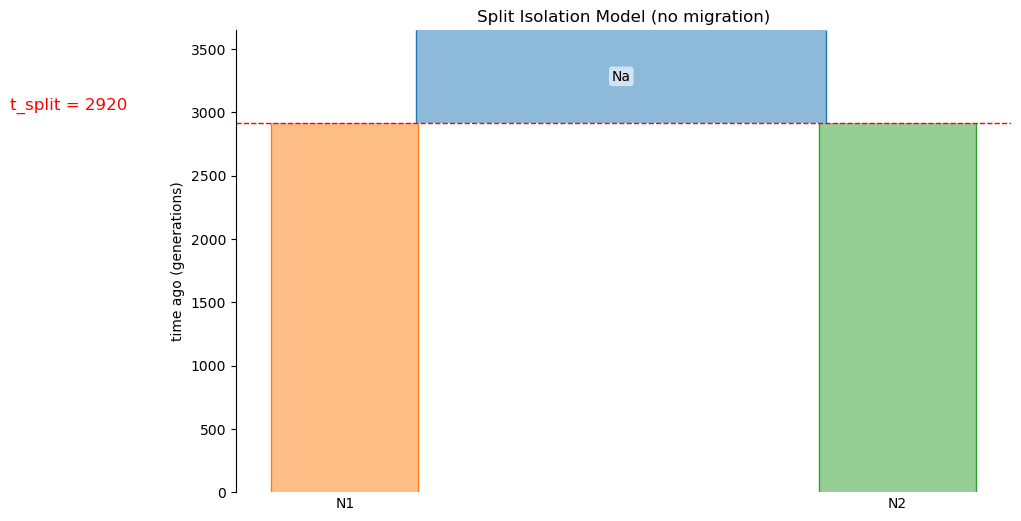

In [85]:
# Plot the graph
fig, ax = plt.subplots(figsize=(10, 6))
demesdraw.tubes(graph=g, title="Split Isolation Model (no migration)", ax=ax)

# Add t_split line and label
ax.axhline(y=sampled_params["t_split"], color="red", linestyle="--", linewidth=1)
ax.text(0.5, sampled_params["t_split"] + 100, f"t_split = {sampled_params['t_split']}",
        color="red", fontsize=12, ha="center")

plt.show()

In [42]:
for migration in g.migrations:
    print(migration)

In [7]:
def create_SFS(
    sampled_params, mode, num_samples, demographic_model, length=1e7, mutation_rate=5.7e-9, recombination_rate = 3.386e-9, **kwargs
):
    """
    If we are in pretraining mode we will use a simulated SFS. If we are in inference mode we will use a real SFS.

    """

    if mode == "pretrain":
        # Simulate the demographic model
        g = demographic_model(sampled_params)
        demog = msprime.Demography.from_demes(g)

        # Dynamically define the samples using msprime.SampleSet, based on the sample_sizes dictionary
        samples = [
            msprime.SampleSet(sample_size, population=pop_name, ploidy=1)
            for pop_name, sample_size in num_samples.items()
        ]

        # Simulate ancestry for two populations (joint simulation)
        ts = msprime.sim_ancestry(
            samples=samples,  # Two populations
            demography=demog,
            sequence_length=length,
            recombination_rate=recombination_rate,
            random_seed=295,
        )

        # Check the samples for each population dynamically
        for pop in ts.populations():
            print(f"Population {pop.id} samples:", ts.samples(population=pop.id))

        
        # Simulate mutations over the ancestry tree sequence
        ts = msprime.sim_mutations(ts, rate=mutation_rate)

        # Define sample sets dynamically for the SFS
        sample_sets = [
            ts.samples(population=pop.id) 
            for pop in ts.populations() 
            if len(ts.samples(population=pop.id)) > 0  # Exclude populations with no samples
        ]
        
        # Create the joint allele frequency spectrum
        sfs = ts.allele_frequency_spectrum(sample_sets=sample_sets, mode="site", polarised=True)
        
        # Multiply SFS by the sequence length to adjust scale
        sfs *= length

        # Convert to moments Spectrum for further use
        sfs = moments.Spectrum(sfs)
    
    elif mode == "inference":
        vcf_file = kwargs.get("vcf_file", None)
        pop_file = kwargs.get("pop_file", None)
        popname = kwargs.get("popname", None)

        if vcf_file is None or pop_file is None:
            raise ValueError(
                "vcf_file and pop_file must be provided in inference mode."
            )

        dd = dadi.Misc.make_data_dict_vcf(vcf_file, pop_file)
        sfs = dadi.Spectrum.from_data_dict(
            dd, [popname], projections=[2 * num_samples], polarized=True
        )

    return sfs

In [ ]:
sample_sizes = {
    "N1": 15,  # 15 samples from population 1
    "N2": 8    # 8 samples from population 2
}

sfs = create_SFS(
    sampled_params, 'pretrain', sample_sizes, demographic_model = split_isolation_model_simulation, length=1e8, mutation_rate=5.7e-9, recombination_rate = 3.386e-9)

In [ ]:
sfs.shape

In [10]:
from src.parameter_inference import run_inference_dadi, run_inference_moments
from src.demographic_models import split_isolation_model_dadi, split_isolation_model_moments

In [ ]:
sampled_params

In [12]:
p0 = [sampled_params["N1"]/sampled_params['Na'], sampled_params["N2"]/sampled_params['Na'], sampled_params["t_split"]/(2*sampled_params['Na']), sampled_params["m"]/(2*sampled_params['Na'])]
num_samples = [sample_sizes['N1'], sample_sizes['N2']]
demographic_model = "split_isolation_model"
k = 3

In [ ]:
p0

In [14]:
demographic_model = "split_isolation_model"

In [15]:
import src.demographic_models as demographic_models
num_samples = 100

In [ ]:
model_list, opt_theta_list, opt_params_final_list, ll_list = run_inference_dadi(
    sfs,
    p0,
    num_samples = 100,
    demographic_model = demographic_model,
    k = k,
    lower_bound=[1e-12, 1e-12, 1e-12, 1e-12], # [N1, N2 , t_split, m]
    upper_bound=[None, None, None, 1e-4], # [N1, N2, t_split, m]
    mutation_rate=mutation_rate,
    length=1e8,
    top_values_k = 1
)

In [ ]:
sampled_params['Na']

In [ ]:
model_list[0].shape

In [ ]:
plt.figure()
plt.imshow(model_list[0])

In [ ]:
plt.figure()
plt.imshow(sfs)

In [ ]:
opt_params_final_list[0]

In [ ]:
sampled_params

In [ ]:
model_list, opt_theta_list, opt_params_final_list, ll_list = run_inference_moments(
    sfs,
    p0,
    demographic_model = demographic_model,
    k = k,
    lower_bound=[1e-4, 1e-4, 1e-4, 1e-12], # [N1, N2 , t_split, m]
    upper_bound=[None, None, None, 1e-4], # [N1, N2, t_split, m]
    mutation_rate=mutation_rate,
    length=1e8,
    top_values_k = 1
)

In [ ]:
opt_params_final_list[0]

In [ ]:
sampled_params

In [ ]:
model_list[0].shape

# Moments LD

In [2]:
upper_bound_params = {
    "t_split": 5000, 
    "m": 1e-4,
    "N1": 10000,
    "N2": 10000,
    "Na": 20000
}

lower_bound_params =  {
    "t_split": 100, 
    "m": 1e-8,
    "N1": 100,
    "N2": 100,
    "Na": 100

}

In [3]:
def sample_params():
    sampled_params = {}
    for key in lower_bound_params:
        lower_bound = lower_bound_params[key]
        upper_bound = upper_bound_params[key]
        sampled_value = np.random.uniform(lower_bound, upper_bound)

        # Initialize adjusted_value with sampled_value by default
        adjusted_value = sampled_value

        # Check if the sampled parameter is equal to the mean of the uniform distribution
        mean_value = (lower_bound + upper_bound) / 2
        if sampled_value == mean_value:
            # Add a small random value to avoid exact mean, while keeping within bounds
            adjustment = np.random.uniform(-0.1 * (upper_bound - lower_bound), 0.1 * (upper_bound - lower_bound))
            adjusted_value = sampled_value + adjustment
            # Ensure the adjusted value is still within the bounds
            adjusted_value = max(min(adjusted_value, upper_bound), lower_bound)

        # Assign adjusted_value to sampled_params
        if key == "m":
            sampled_params[key] = adjusted_value
        else:
            sampled_params[key] = int(adjusted_value)

    return sampled_params

In [4]:
sampled_params = sample_params()
print(sampled_params)

{'t_split': 1412, 'm': 3.747457207511364e-05, 'N1': 3430, 'N2': 2260, 'Na': 5579}


In [5]:
import os
os.chdir('/sietch_colab/akapoor/Demographic_Inference/')

In [6]:
from src.demographic_models import split_isolation_model_simulation

In [7]:
# from src.parameter_inference import run_inference_momentsLD
import src.demographic_models as demographic_models
# from src.demographic_models import split_isolation_model_momentsLD
from src.preprocess import Processor
import json

In [8]:
demographic_model = demographic_models.split_isolation_model_simulation
sim_directory = '/sietch_colab/akapoor/Demographic_Inference/split_isolation_testing'
sim_number = 1

with open("/sietch_colab/akapoor/Demographic_Inference/experiment_config.json") as f:
    experiment_config = json.load(f)

mutation_rate = experiment_config['mutation_rate']
recombination_rate = experiment_config['recombination_rate']
length = experiment_config['genome_length']
window_length = experiment_config['window_length']

In [9]:
# Simulate process and save windows as VCF files
g = demographic_model(sampled_params)

In [10]:
directory_for_windows = f"{sim_directory}/sampled_genome_windows/sim_{sim_number}"
Processor.run_msprime_replicates(experiment_config, g, directory_for_windows)
print("MSPRIME REPLICATES DONE!!!!!!")
samples_file, flat_map_file = Processor.write_samples_and_rec_map(experiment_config, directory_for_windows)
print("SAMPLES AND REC MAP WRITTEN!!!!!!")

100%|██████████| 100/100 [00:04<00:00, 23.13it/s]

Metadata file written to /sietch_colab/akapoor/Demographic_Inference/split_isolation_testing/sampled_genome_windows/sim_1/metadata.txt
MSPRIME REPLICATES DONE!!!!!!
SAMPLES AND REC MAP WRITTEN!!!!!!


In [32]:
flat_map_path = '/sietch_colab/akapoor/Demographic_Inference/split_isolation_testing/sampled_genome_windows/sim_1/flat_map.txt'
samples_path = '/sietch_colab/akapoor/Demographic_Inference/split_isolation_testing/sampled_genome_windows/sim_1/samples.txt'
metadata_path = '/sietch_colab/akapoor/Demographic_Inference/split_isolation_testing/sampled_genome_windows/sim_1/metadata.txt'
p_guess = [sampled_params["N1"]/sampled_params['Na'], sampled_params["N2"]/sampled_params['Na'], sampled_params["t_split"]/(2*sampled_params['Na']), 0.1, 5000] # Not sure if I need to provide the ancestral population size
demographic_model = "split_isolation_model"


In [15]:
sampled_params

{'t_split': 1412,
 'm': 3.747457207511364e-05,
 'N1': 3430,
 'N2': 2260,
 'Na': 5579}

In [33]:
p_guess

[0.6148055207026348, 0.405090518013981, 0.12654597598135867, 0.1, 5000]

In [17]:
import ray

In [18]:
@ray.remote
def get_LD_stats(vcf_file, r_bins, flat_map_path, pop_file_path):
    # start_time = time.time()
    ld_stats = moments.LD.Parsing.compute_ld_statistics(  # type: ignore
        vcf_file,
        rec_map_file=flat_map_path,
        pop_file=pop_file_path,
        pops=["N1", "N2"], #TODO: FIX LATER
        r_bins=r_bins,
        report=False,
    )
    # end_time = time.time()

    # print(f"LD stats for {vcf_file} computed in {end_time - start_time} seconds")

    return ld_stats


In [19]:
def compute_ld_stats_parallel(folderpath, num_reps, r_bins):
    flat_map_path = os.path.join(folderpath, "flat_map.txt")
    pop_file_path = os.path.join(folderpath, "samples.txt")
    vcf_files = [
        os.path.join(folderpath, f"window.{rep_ii}.vcf.gz")
        for rep_ii in range(num_reps)
    ]

    # Launch the tasks in parallel using Ray
    futures = [
        get_LD_stats.remote(vcf_file, r_bins, flat_map_path, pop_file_path)
        for vcf_file in vcf_files
    ]

    # Wait for all the tasks to complete and retrieve results
    results = ray.get(futures)
    return results

In [20]:
# def compute_ld_stats_sequential(flat_map_path, samples_path, metadata_path, r_bins):
#     # Start by defining paths
    
#     # List of VCF files
#     # Read the file and store each line (filepath) into a list
#     with open(metadata_path, 'r') as f:
#         vcf_files = [line.strip() for line in f]

#     # List to store LD statistics results
#     ld_stats_list = []

#     # Sequentially compute LD statistics for each VCF file
#     for vcf_file in vcf_files:
#         ld_stats = get_LD_stats(vcf_file, r_bins, flat_map_path, samples_path)
#         ld_stats_list.append(ld_stats)
    
#     return ld_stats_list


In [21]:
def run_inference_momentsLD(
    flat_map_path, samples_path, metadata_path, p_guess, demographic_model, maxiter=20
):
    """
    This should do the parameter inference for momentsLD
    index: unique simulation number
    """

    r_bins = np.array([0, 1e-6, 2e-6, 5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3])

    print("parsing LD statistics")

    ld_stats = {}
    results = compute_ld_stats_parallel(flat_map_path, samples_path, experiment_config['num_windows'], r_bins)

    for i, result in enumerate(results):
        ld_stats[i] = result

    # print("computing mean and varcov matrix from LD statistics sums")
    mv = moments.LD.Parsing.bootstrap_data(ld_stats)  # type: ignore
    print("SHAPE OF THE COVARIANCE MATRIX")
    print(mv["varcovs"][-1].shape)
    # mv["varcovs"][-1].shape = (1, 1)

    if demographic_model == "bottleneck_model":
        demo_func = moments.LD.Demographics1D.three_epoch # type: ignore

    elif demographic_model == "split_isolation_model":
        demo_func = demographic_models.split_isolation_model_momentsLD

    else:
        raise ValueError(f"Unsupported demographic model: {demographic_model}")

    # Set up the initial guess
    p_guess = moments.LD.Util.perturb_params(p_guess, fold=1)  # type: ignore
    
    # Define necessary arguments for the new opt function
    # p0 = p_guess  # Initial parameters guess
    # data = [mv["means"], mv["varcovs"]]  # Means and varcovs
    # model_func = demo_func  # Demographic model function
    # func_args = [r_bins]  # Pass r_bins as part of additional function arguments
    # ftol_abs = 1e-6  # You can specify or adjust these based on your use case
    # xtol_abs = 1e-6
    # maxeval = maxiter  # Use maxiter as max function evaluations   
    
    # opt_params, LL = ld_opt(
    #     p0=p0,
    #     data=data,
    #     model_func=model_func,
    #     lower_bound=None,  # Add your actual lower bounds if applicable
    #     upper_bound=None,  # Add your actual upper bounds if applicable
    #     func_args=func_args,
    #     ftol_abs=ftol_abs,
    #     xtol_abs=xtol_abs,
    #     maxeval=maxeval,
    #     verbose=0
    # )

    opt_params, LL = moments.LD.Inference.optimize_log_lbfgsb( #type:ignore
    p_guess, [mv["means"], mv["varcovs"]], [demo_func], rs=r_bins, verbose = 3
    )

    opt_params_dict = {}
    if demographic_model == "bottleneck_model":

        opt_params_dict = {
            # "N0": opt_params[4],
            "Nb": opt_params[0] * opt_params[4],
            "N_recover": opt_params[1] * opt_params[4],
            "t_bottleneck_start": (opt_params[2]+opt_params[3]) * 2 * opt_params[4],
            "t_bottleneck_end": opt_params[3] * 2 * opt_params[4]
        }

    elif demographic_model == "split_isolation_model":
        physical_units = moments.LD.Util.rescale_params( #type:ignore
        opt_params, ["nu", "nu", "T", "Ne"]
        )

        print(physical_units)

        opt_params_dict = {
            "N1": physical_units[0],
            "N2": physical_units[1],
            "t_split": physical_units[2]
        }
    
    print(f'Moments LD results: {opt_params_dict}')

    return opt_params_dict


In [22]:
r_bins = np.array([0, 1e-6, 2e-6, 5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3])
folderpath = '/sietch_colab/akapoor/Demographic_Inference/split_isolation_testing/sampled_genome_windows/sim_1'
print("parsing LD statistics")

ld_stats = {}
results = compute_ld_stats_parallel(folderpath, experiment_config['num_windows'], r_bins)

for i, result in tqdm(enumerate(results)):
    ld_stats[i] = result


parsing LD statistics


2024-10-14 12:03:49,807	INFO worker.py:1781 -- Started a local Ray instance.
100it [00:00, 544714.81it/s]


In [23]:
ld_stats[0]

{'bins': [(0.0, 1e-06),
  (1e-06, 2e-06),
  (2e-06, 5e-06),
  (5e-06, 1e-05),
  (1e-05, 2e-05),
  (2e-05, 5e-05),
  (5e-05, 0.0001),
  (0.0001, 0.0002),
  (0.0002, 0.0005),
  (0.0005, 0.001)],
 'sums': [array([ 0.15931875,  0.11144887,  0.11635349,  0.06188198, -0.01807359,
         -0.05845571,  0.24048609,  0.17905619,  0.19519336,  0.77045739,
          0.73222252,  0.63807013,  0.71532464,  0.63920629,  0.58510349]),
  array([ 0.13452951,  0.09458556,  0.11459695,  0.13797562,  0.18291246,
          0.26633633,  0.05459002, -0.00832776,  0.04266068,  0.58257718,
          0.59268503,  0.55184637,  0.61837165,  0.58393331,  0.55382285]),
  array([0.58044543, 0.37463394, 0.40355392, 0.29506152, 0.2752886 ,
         0.37296636, 0.3379276 , 0.18389316, 0.2939951 , 2.59930508,
         2.58422318, 2.38835307, 2.59225881, 2.40500188, 2.23125   ]),
  array([ 0.89449761,  0.60389434,  0.58910675,  0.82886193,  0.83781566,
          1.15753119,  0.03047633, -0.1893568 ,  0.1524646 ,  4.3881

In [24]:
print("computing mean and varcov matrix from LD statistics sums")
mv = moments.LD.Parsing.bootstrap_data(ld_stats)

computing mean and varcov matrix from LD statistics sums


In [25]:
mv.keys()

dict_keys(['bins', 'stats', 'pops', 'means', 'varcovs'])

In [26]:
len(mv['varcovs'])

11

In [27]:
mv['varcovs'][0].shape

(15, 15)

In [28]:
demo_func = moments.LD.Demographics2D.split_mig

In [29]:
p_guess

[0.6148055207026348, 0.405090518013981, 0.12654597598135867, 0, 5000]

In [34]:
p_guess = moments.LD.Util.perturb_params(p_guess, fold=0.1)
opt_params, LL = moments.LD.Inference.optimize_log_lbfgsb(
    p_guess, [mv["means"], mv["varcovs"]], [demo_func], rs=r_bins, verbose = 3
)

physical_units = moments.LD.Util.rescale_params(
    opt_params, ["nu", "nu", "T", "m", "Ne"]
)

15      , -669927     , array([ 0.600158   ,  0.420802   ,  0.125983   ,  0.0999428  ,  5297.07    ])
18      , -672599     , array([ 0.600158   ,  0.420802   ,  0.126109   ,  0.0999428  ,  5297.07    ])
21      , -43225.9    , array([ 0.872238   ,  0.706919   ,  0.0585841  ,  0.102007   ,  5661.4     ])
24      , -43217.4    , array([ 0.872238   ,  0.706919   ,  0.0586427  ,  0.102007   ,  5661.4     ])
27      , -42515.8    , array([ 0.875359   ,  0.707824   ,  0.0587184  ,  0.102008   ,  5739.17    ])
30      , -42507.5    , array([ 0.875359   ,  0.707824   ,  0.0587772  ,  0.102008   ,  5739.17    ])
33      , -39804.8    , array([ 0.887955   ,  0.711455   ,  0.0592589  ,  0.102009   ,  6061.11    ])
36      , -39797.4    , array([ 0.887955   ,  0.711455   ,  0.0593181  ,  0.102009   ,  6061.11    ])
39      , -30811.3    , array([ 0.940179   ,  0.726168   ,  0.0614708  ,  0.102016   ,  7539.86    ])
42      , -30806.9    , array([ 0.940179   ,  0.726168   ,  0.0615323  ,  0.102016

In [35]:
print("Simulated parameters:")
print(f"  N(deme0)         :  {g.demes[1].epochs[0].start_size:.1f}")
print(f"  N(deme1)         :  {g.demes[2].epochs[0].start_size:.1f}")
print(f"  Div. time (gen)  :  {g.demes[1].epochs[0].start_time:.1f}")
print(f"  Migration rate   :  {g.migrations[0].rate:.6f}")
print(f"  N(ancestral)     :  {g.demes[0].epochs[0].start_size:.1f}")

print("best fit parameters:")
print(f"  N(deme0)         :  {physical_units[0]:.1f}")
print(f"  N(deme1)         :  {physical_units[1]:.1f}")
print(f"  Div. time (gen)  :  {physical_units[2]:.1f}")
print(f"  Migration rate   :  {physical_units[3]:.6f}")
print(f"  N(ancestral)     :  {physical_units[4]:.1f}")

Simulated parameters:
  N(deme0)         :  3430.0
  N(deme1)         :  2260.0
  Div. time (gen)  :  1412.0
  Migration rate   :  0.000037
  N(ancestral)     :  5579.0
best fit parameters:
  N(deme0)         :  9939.5
  N(deme1)         :  8784.2
  Div. time (gen)  :  13864.1
  Migration rate   :  0.000208
  N(ancestral)     :  3862.6


In [ ]:
opt_params

In [49]:
physical_units = moments.LD.Util.rescale_params(
    opt_params, ["nu", "nu", "T", "m", "Ne"]
)

In [ ]:
physical_units

In [ ]:
physical_units[0]

In [ ]:
sampled_params['Na']

In [ ]:
demographic_model = "split_isolation_model"
opt_params_dict = run_inference_momentsLD(flat_map_path, samples_path, metadata_path, p_guess, demographic_model, maxiter=100)

In [2]:
import pickle

with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_seed_42/sims/sims_pretrain_2_sims_inference_1_seed_42_num_replicates_10_top_values_5/simulation_results/software_inferences_sim_0.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data

{'simulated_params': {'t_split': 4235,
  'N1': 566,
  'N2': 1672,
  'Na': 14696,
  'm': 0},
 'sfs': Spectrum([[-- 103.0 34.0 34.0 14.0 41.0 6.0 5.0 2.0 4.0 6.0 1.0 2.0 2.0 1.0 12.0
   3.0 53.0 0.0 0.0 432.0]
  [19.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   0.0 0.0 0.0 0.0]
  [18.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   0.0 0.0 0.0 0.0]
  [12.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   0.0 0.0 0.0 0.0]
  [32.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   0.0 0.0 0.0 0.0]
  [6.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   0.0 0.0 0.0]
  [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   0.0 0.0 0.0]
  [5.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
   0.0 0.0 0.0]
  [2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0